In [1]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch_geometric as pyg
import torch as th

from src import dataloader
from src import dataviewer
from src import dataanalysis

In [114]:
importlib.reload(dataviewer)
importlib.reload(dataanalysis)

<module 'src.dataanalysis' from '/home/mf/Documents/Github/ML_Self_Course/Kaggle/Trade_Network/src/dataanalysis.py'>

In [4]:
# read the pajek file. ignore the last column (z)
G_2000 = nx.read_pajek('../dataset/2000.net')
# drop the z column
for node in G_2000.nodes:
    G_2000.nodes[node].pop('shape')
    G_2000.nodes[node].pop('x')
    G_2000.nodes[node].pop('y')

In [90]:
A_2000 = nx.adjacency_matrix(G_2000)

In [91]:
# get country id
country_id = {}
for i, node in enumerate(G_2000.nodes):
    country_id[node] = i

In [106]:
def imports_exports(G, country):
    A = nx.adjacency_matrix(G)
    id = int(G.nodes[country]['id'])-1
    imports = np.sum(A[id, :])
    exports = np.sum(A[:, id])
    return imports, exports

In [108]:
imports_exports(G_2000, 'USA')

153


(1171953977.3519998, 777795850.816)

In [89]:
# read the first ten edges with Albania as the source
albania_imports = 0
for ie, e in enumerate(G_2000['ALB']):
    print(e, G_2000['ALB'][e])
    albania_imports += G_2000['ALB'][e][0]['weight']
print(f"Total imports of Albania in 2000: {albania_imports*1000:.2e} U$D")

ARE {0: {'weight': 1197.07}}
ARG {0: {'weight': 162.552}}
ARM {0: {'weight': 147.911}}
AUS {0: {'weight': 776.949}}
AUT {0: {'weight': 11840.4}}
AZE {0: {'weight': 7.847}}
BEL {0: {'weight': 2936.27}}
BGR {0: {'weight': 25911.9}}
BIH {0: {'weight': 91.588}}
BLR {0: {'weight': 6895.03}}
BOL {0: {'weight': 16.033}}
BRA {0: {'weight': 1187.76}}
CAF {0: {'weight': 0.629}}
CAN {0: {'weight': 1463.84}}
CHE {0: {'weight': 13422.0}}
CHN {0: {'weight': 14696.6}}
CIV {0: {'weight': 19.97}}
COL {0: {'weight': 1030.44}}
CRI {0: {'weight': 46.608}}
CYP {0: {'weight': 3181.61}}
CZE {0: {'weight': 5927.99}}
DEU {0: {'weight': 66369.8}}
DNK {0: {'weight': 3831.2}}
ECU {0: {'weight': 3130.79}}
EGY {0: {'weight': 2126.33}}
ESP {0: {'weight': 12677.2}}
EST {0: {'weight': 22.94}}
FIN {0: {'weight': 5833.02}}
FRA {0: {'weight': 14976.9}}
GBR {0: {'weight': 8785.13}}
GEO {0: {'weight': 183.13}}
GRC {0: {'weight': 288023.0}}
HKG {0: {'weight': 664.399}}
HRV {0: {'weight': 12883.9}}
HTI {0: {'weight': 1.097}}

In [29]:

f# first row is header
coordinates = pd.read_csv('./coordinates.csv', header=0, sep='\t')
# strip spaces in column names
coordinates.columns = coordinates.columns.str.strip()
# get the land area of each country in mi^2. 
# this is used to scale the node size
country_area = pd.read_csv('./country_data.csv')
# keep only country name and area
country_area = country_area[['Country', 'Area (sq. mi.)']]

In [57]:
# find 'AG' entry in coordinates
coordinates[coordinates['country'].str.match('AG')][['latitude', 'longitude']].values[0]

array([ 17.060816, -61.796428])

In [61]:
coordinates['latitude'].max()

77.553604

In [62]:
np.tan(77.55/180*np.pi)

4.529410453326322

In [71]:
%matplotlib qt

fig, ax = plt.subplots(figsize=(10, 10))

# set background to ./Mercator_projection_Square.JPG. set range to [0, 1, 0, 1]
ax.imshow(plt.imread('./mercator.png'), zorder=-10, extent=[-1, 1, -1, 1])


pos = {}
for node in G_2000.nodes:
    alpha_2 = dataviewer.country_info(node).alpha_2
    try:
        pos[node] = coordinates[coordinates['country'].str.match(alpha_2)][['longitude', 'latitude']].values[0]
        # conert x,y coordinates
        pos[node][0] = pos[node][0]/180
        pos[node][1] = np.log( np.tan(pos[node][1]/180*np.pi/2 + np.pi/4) ) / np.pi
    except:
        pass
node_size = []
for node in G_2000.nodes:
    country_name = dataviewer.country_info(node).name
    try:
        area = country_area[country_area['Country'].str.match(country_name)]['Area (sq. mi.)'].values[0]
    except:
        pass
    # scale size between 10 and 200, based on area (min area is 2, max area is 1,648,000)
    node_size.append( min(10 + (area-2)/(17075200-2)*(200-10), 20) )

nx.draw_networkx_nodes(G_2000, pos, node_size=node_size, node_color='red', ax=ax)

# draw axes with ticks
ax.set_xticks(np.arange(-1, 1.1, 0.2))
ax.set_yticks(np.arange(-85/90, 85/90+0.1, 10/90))
ax.set_xticklabels(np.arange(-180, 180+1, 36))
ax.set_yticklabels(np.arange(-85, 85+1, 10))


# crop the image on the y axis to 0.25-0.5
#ax.set_ylim(0.2, 0.85)

[]

In [ ]:
0.737, 0.374

In [110]:
dataset_dir = '../dataset/'
# get all files in the dataset directory
files = os.listdir(dataset_dir)
# sort the files alphanumerically
files.sort()
# load all the graphs
G_Years = {}
for file in files:
    print("Loading", file, "...", end=' ')
    G_Years[file.strip("'").strip('.net')] = dataloader.load_pajek(dataset_dir + file)
    print("Done", end=' | ')

Loading 2000.net ... Done | Loading 2005.net ... Done | Loading 2010.net ... Done | Loading 2015.net ... Done | Loading 2018.net ... Done | 

In [3]:
# get list of countries
countries = list(G_Years['2000'].nodes)

In [4]:
dataviewer.country_info('MEX')

Country(alpha_2='MX', alpha_3='MEX', flag='🇲🇽', name='Mexico', numeric='484', official_name='United Mexican States')

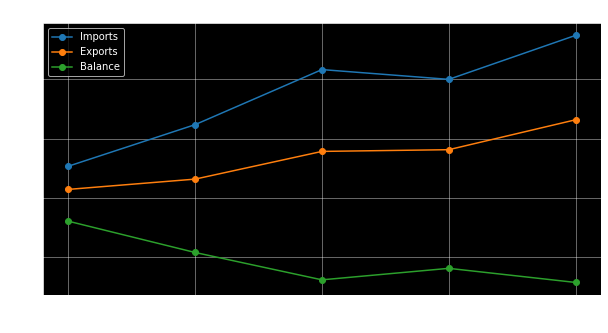

In [115]:
%matplotlib inline
fig, ax = dataviewer.country_exports_imports_yearly_graph(G_Years=G_Years, country='Alb')
fig.savefig('exports_imports_alb.png', dpi=300)

In [11]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:xlabel='Year', ylabel='Deficit (USD)'>)

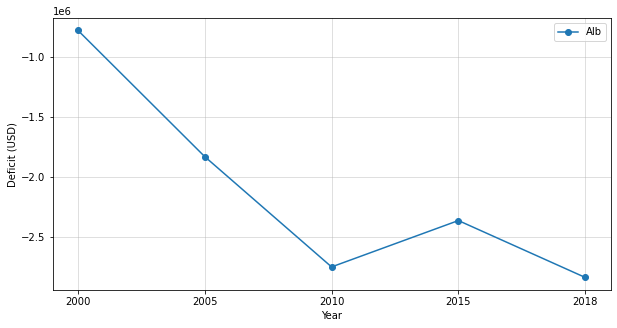

In [10]:
dataviewer.deficit_graph(G_Years=G_Years, country='Alb')

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:xlabel='Year', ylabel='Trade (USD)'>)

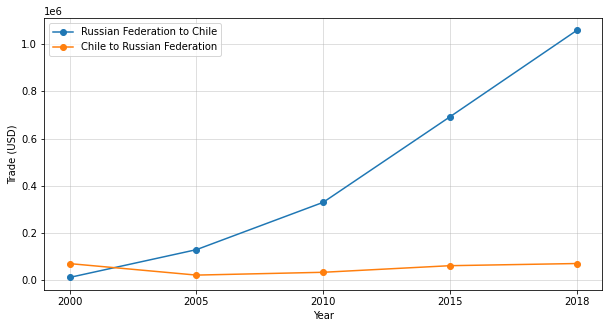

In [6]:
dataviewer.cross_country_trades_graph(G_Years=G_Years, country_1='Rus', country_2='CHIle')

In [146]:
declining_exports_countries = dataanalysis.declining_imports_or_exports(G_Years, 'exports')

In [2]:
eigenvector_centralities = dataanalysis.get_centralities(G_Years, type_of_centrality='eigenvector')
degree_centralities = dataanalysis.get_centralities(G_Years, type_of_centrality='degree')
betweenness_centralities = dataanalysis.get_centralities(G_Years, type_of_centrality='betweenness')
closeness_centralities = dataanalysis.get_centralities(G_Years, type_of_centrality='closeness')

NameError: name 'dataanalysis' is not defined

(<Figure size 1296x864 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Eigenvector Centralities'}, xlabel='Year', ylabel='Eigenvector Centrality'>,
         <AxesSubplot:title={'center':'Degree Centralities'}, xlabel='Year', ylabel='Degree Centrality'>],
        [<AxesSubplot:title={'center':'Betweenness Centralities'}, xlabel='Year', ylabel='Betweenness Centrality'>,
         <AxesSubplot:title={'center':'Closeness Centralities'}, xlabel='Year', ylabel='Closeness Centrality'>]],
       dtype=object))

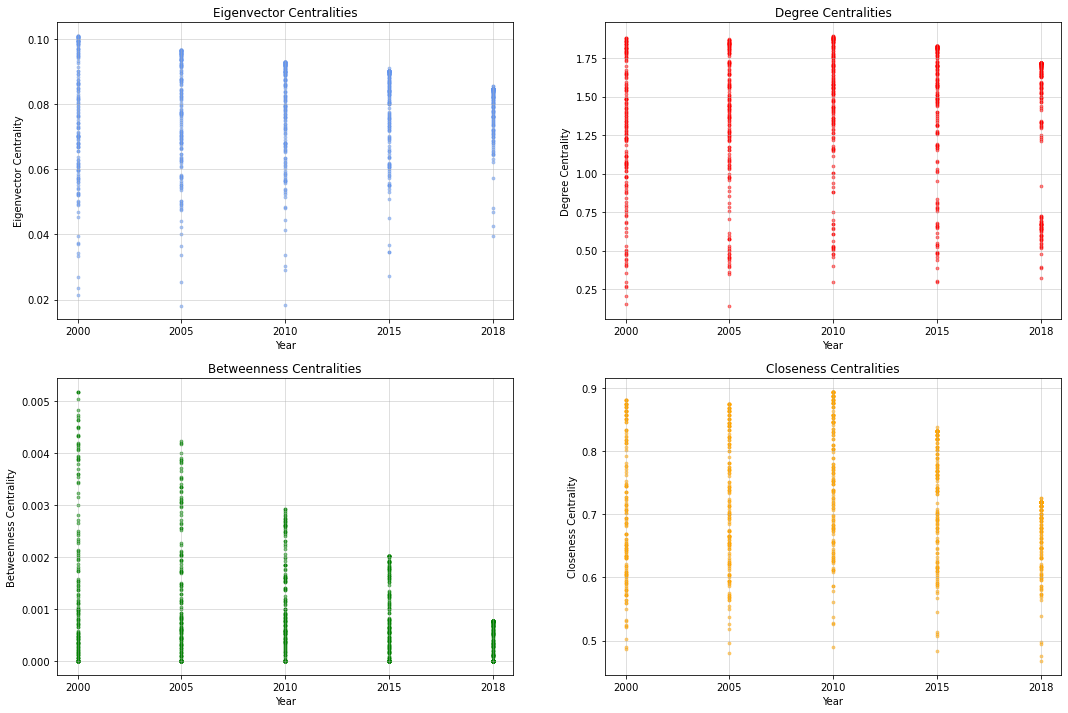

In [14]:
dataviewer.centralities_distribution(eigenvector_centralities, degree_centralities, betweenness_centralities, closeness_centralities)

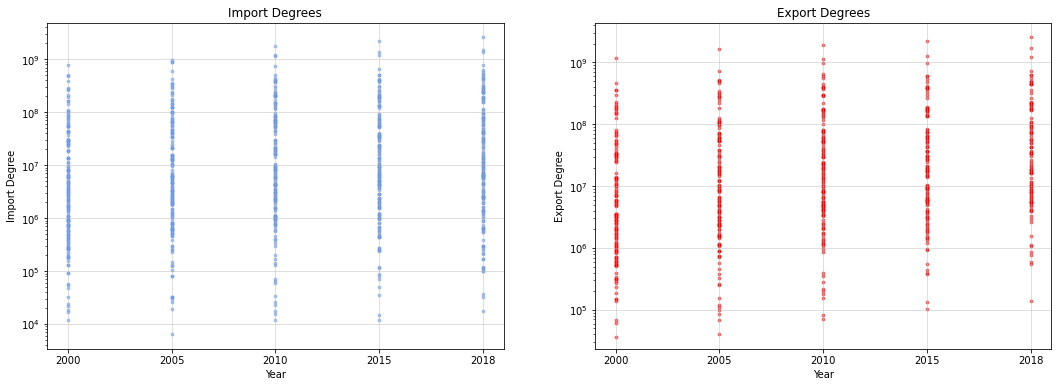

In [16]:
# use the same plot layout to show distribution of degrees of the nodes, as import or export degrees
# this includes using weights
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
for year in degree_centralities.columns:
    years_list = [year] * len(degree_centralities[year])
    import_degrees = G_Years[year].in_degree(weight='weight')
    import_degrees = [degree[1] for degree in import_degrees]
    ax[0].scatter(years_list, import_degrees, c='cornflowerblue', alpha=0.5, s=8)
    export_degrees = G_Years[year].out_degree(weight='weight')
    export_degrees = [degree[1] for degree in export_degrees]
    ax[1].scatter(years_list, export_degrees, c='red', alpha=0.5, s=8)

ax[0].set_title('Import Degrees')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Import Degree')
ax[0].grid(alpha=0.5)
ax[0].set_yscale('log')
ax[1].set_title('Export Degrees')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Export Degree')
ax[1].grid(alpha=0.5)
ax[1].set_yscale('log')

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:xlabel='Year', ylabel='Deficit (USD)'>)

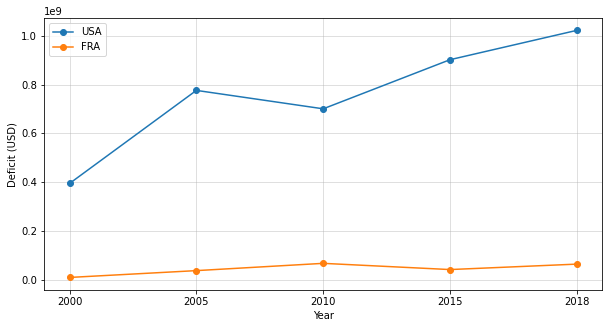

In [32]:
dataviewer.deficit_graph(G_Years, ['USA', 'FRA'])

In [37]:
def deficit_graph(G_Years=None, country=None):
    """
        Plot the deficit of a country (or list of countries) by year.
        args: G_Years: a list of networkx DiGraphs
              country: the name or alpha_2 or alpha_3 code of the country, or a list of countries
        returns: fig, ax (matplotlib)
    """
    if type(country) == str:
        country = [country]
    
    fig, ax = plt.subplots(figsize=(10, 5))
    years = list(G_Years.keys())
    for c in country:
        deficits = dataviewer.deficit_calculator(G_Years=G_Years, country=c)
        ax.scatter(years, deficits, marker='o', alpha=0.5, color='cornflowerblue')
    ax.set_xlabel('Year')
    ax.set_ylabel('Deficit (USD)')
    ax.grid(alpha=0.5)
    return fig, ax

(<Figure size 720x360 with 1 Axes>,
 <AxesSubplot:xlabel='Year', ylabel='Deficit (USD)'>)

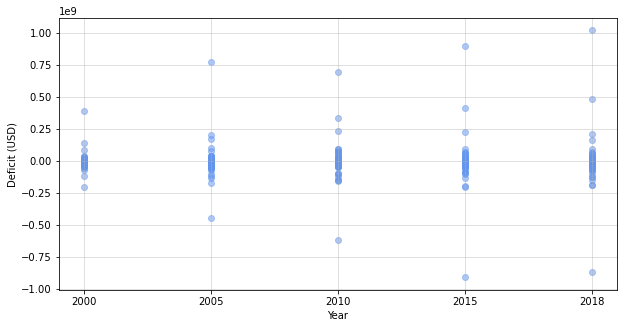

In [38]:
deficit_graph(G_Years, countries)

In [9]:
deficit_pd = pd.DataFrame()
for country in countries:
    deficits = dataviewer.deficit_calculator(G_Years, country)
    deficit_pd[country] = deficits
deficit_pd = deficit_pd.copy()
deficit_pd = deficit_pd.T
# assign years to columns
deficit_pd.columns = list(G_Years.keys())

In [20]:
# get 2000 column, and sort 
deficit_2000 = deficit_pd['2000'].copy()
deficit_2000.sort_values(inplace=True)
deficit_2005 = deficit_pd['2005'].copy()
deficit_2005.sort_values(inplace=True)
deficit_2010 = deficit_pd['2010'].copy()
deficit_2010.sort_values(inplace=True)
deficit_2015 = deficit_pd['2015'].copy()
deficit_2015.sort_values(inplace=True)
deficit_2018 = deficit_pd['2018'].copy()
deficit_2018.sort_values(inplace=True)

In [21]:
# get position of "JPN" in list
deficit_2000.index.get_loc('ARG'), deficit_2005.index.get_loc('ARG'), deficit_2010.index.get_loc('ARG'), deficit_2015.index.get_loc('ARG'), deficit_2018.index.get_loc('ARG')

(40, 23, 25, 112, 133)

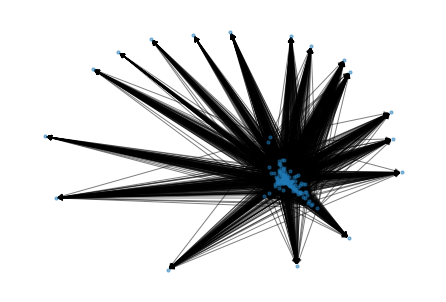

In [23]:
nx.draw(G_Years['2010'], pos=nx.spring_layout(G_Years['2010']), node_size=10, alpha=0.5, with_labels=False)

In [197]:
node_size = []
# set node size by eigenvecor centrality
for node in G_Years['2010'].nodes:
    node_size.append(eigenvector_centralities['2010'][node] * 1000)

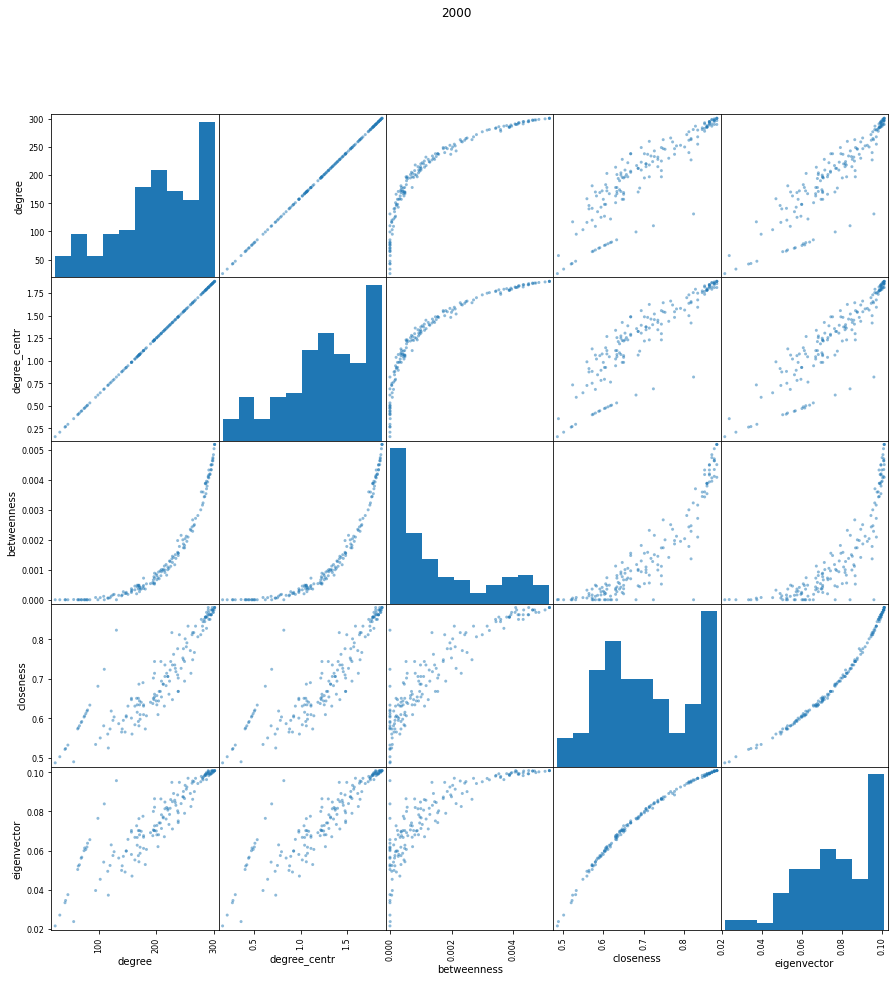

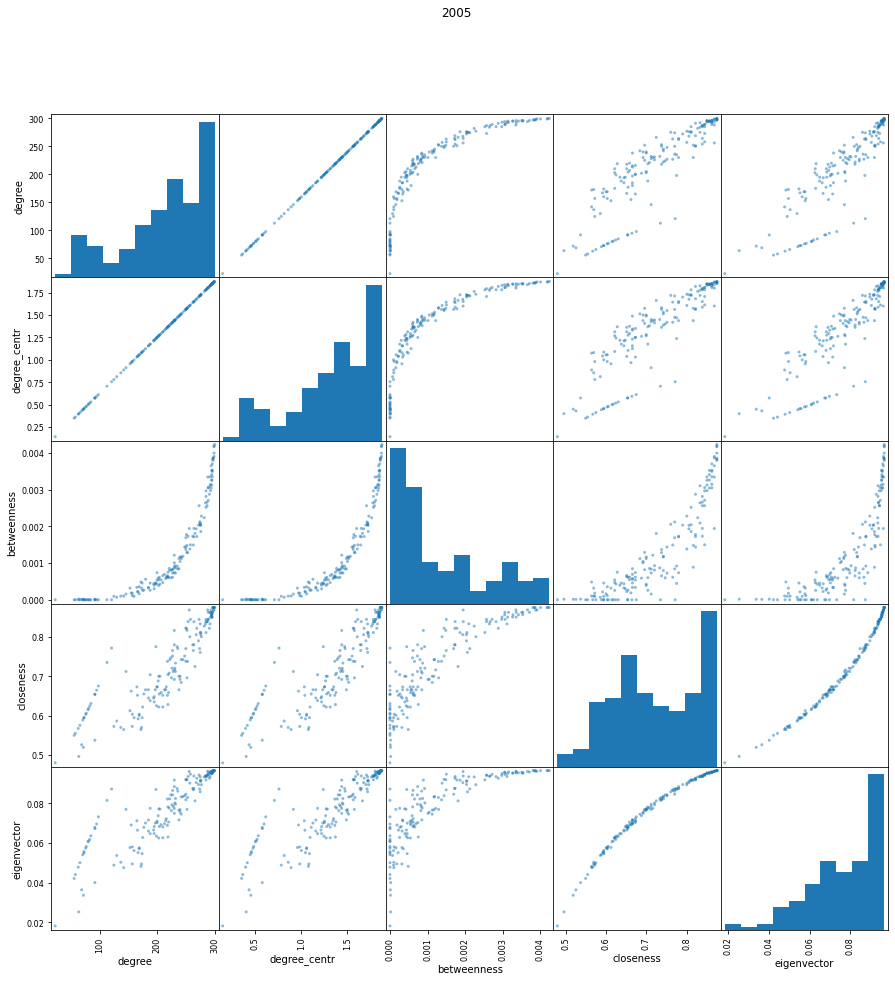

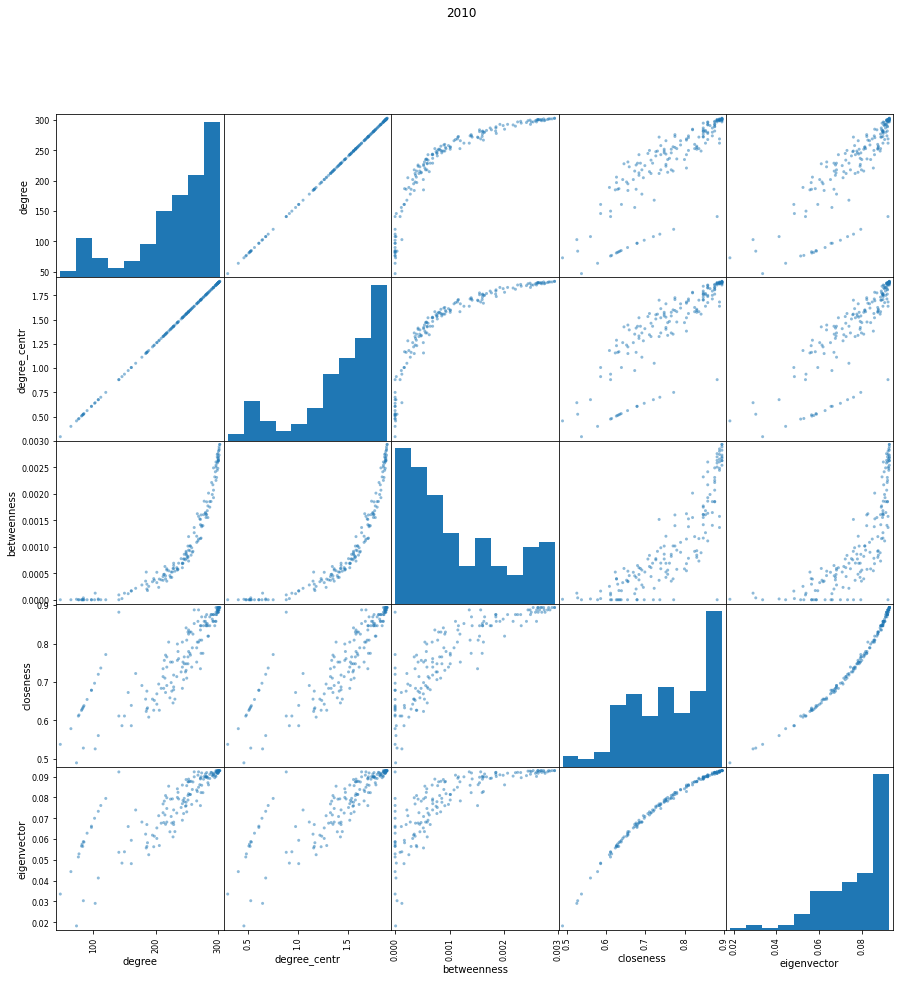

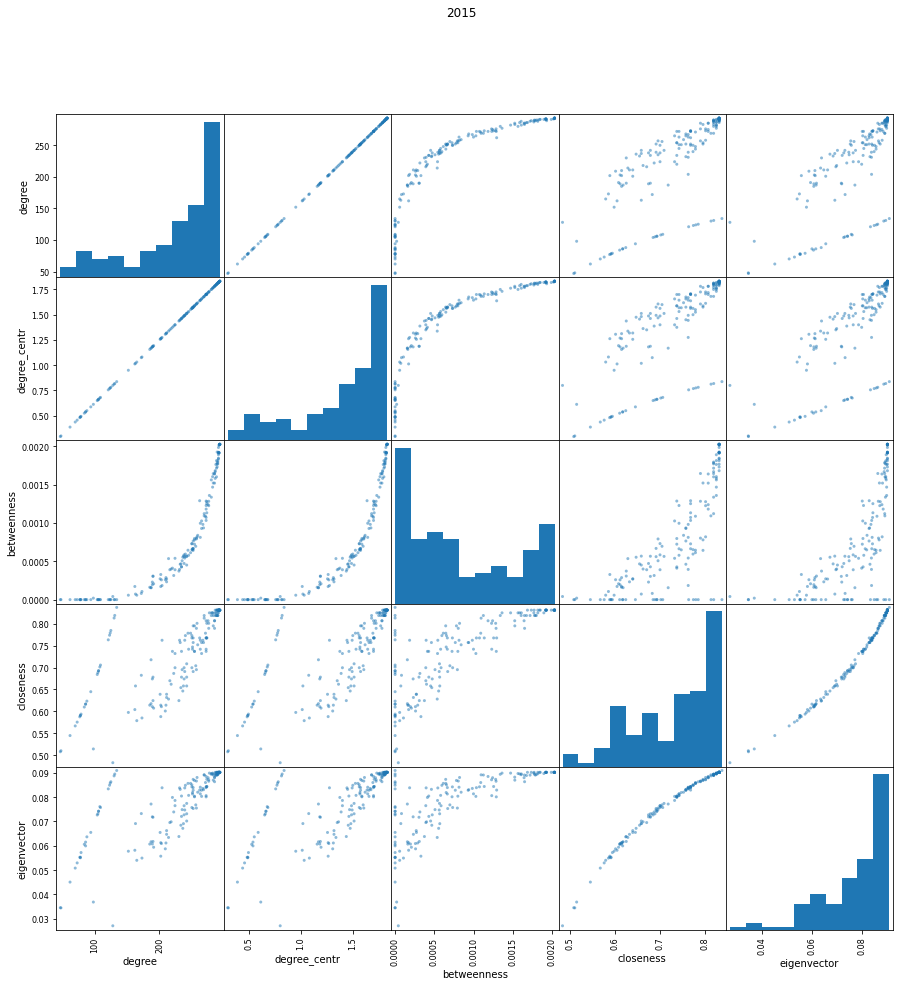

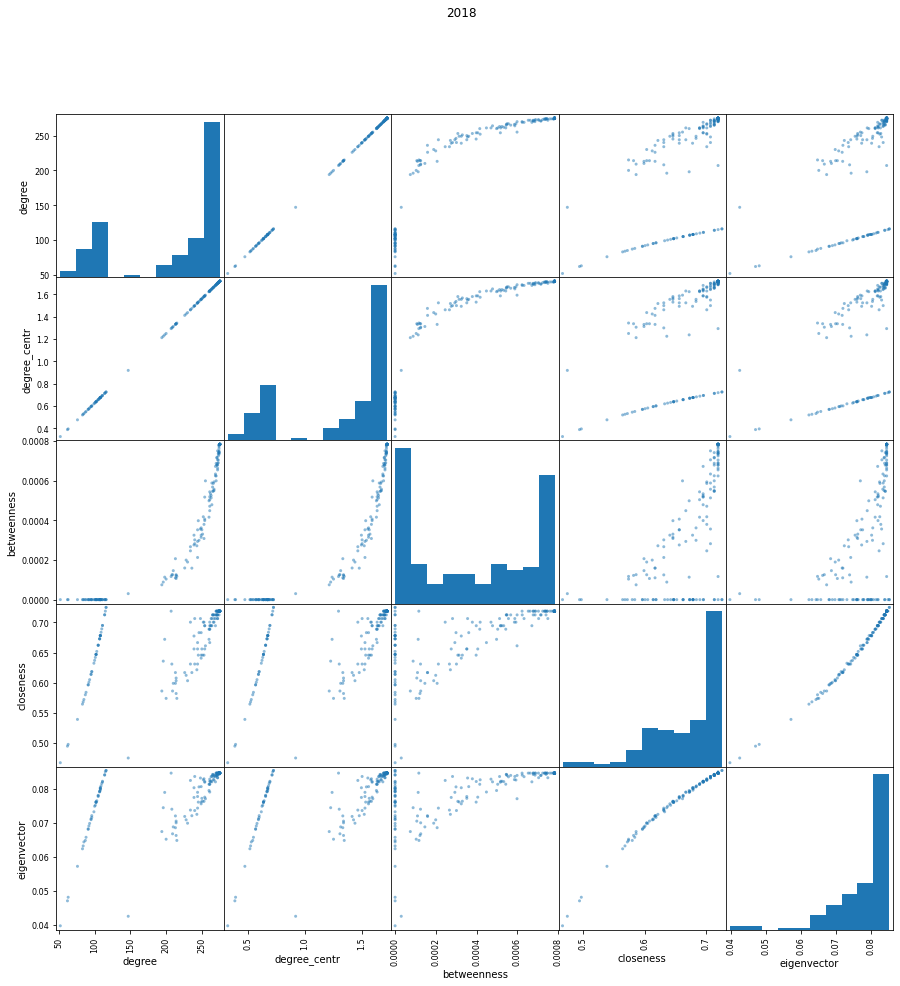

In [19]:
for year in G_Years.keys():
    pd_ = pd.DataFrame(columns=['degree', 'degree_centr', 'betweenness', 'closeness', 'eigenvector'])
    pd_['degree'] = [i[1] for i in G_Years[year].degree]
    pd_['degree_centr'] = degree_centralities[year].values
    pd_['betweenness'] = betweenness_centralities[year].values
    pd_['closeness'] = closeness_centralities[year].values
    pd_['eigenvector'] = eigenvector_centralities[year].values
    # make a scatter matrix of pd_
    pd.plotting.scatter_matrix(pd_, figsize=(15, 15), alpha=0.5)
    # set title to year
    plt.suptitle(year)
    # save the plot to a file
    plt.savefig(f'{year}_centralities_scatter.png')

In [181]:
pos=nx.spring_layout(G_Years['2010'], k=80, iterations=4)
# rescale the positions using a log function, based on the radius of the node (if it is close to the center, push it away more than if it is far away)
# for idx, node in enumerate(pos.keys()):
#     if np.linalg.norm(pos[node]) > 0.1:
#         pos[node] *= 0.2
#     if node_size[idx] < 7:
#         # if the node is small, push it away from the center
#         pos[node] /= np.linalg.norm(pos[node]) * 10

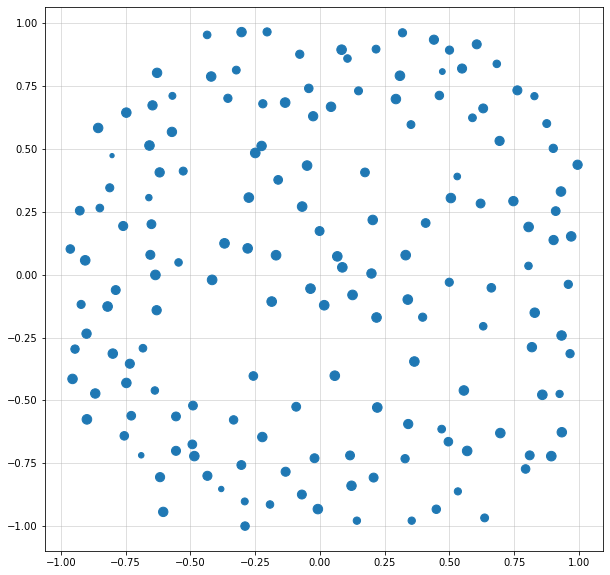

In [201]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx_nodes(G_Years['2010'], pos=pos, node_size=node_size, alpha=1, ax=ax)
# plot ax grid and axis
ax.grid(alpha=0.5)
# turn on axis
ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

In [99]:
nx.average_shortest_path_length(G_Years['2000'], weight='weight'), nx.average_shortest_path_length(G_Years['2005'], weight='weight'), nx.average_shortest_path_length(G_Years['2010'], weight='weight'), nx.average_shortest_path_length(G_Years['2015'], weight='weight'), nx.average_shortest_path_length(G_Years['2018'], weight='weight')

(11.9813814440994,
 9.622856133540399,
 54.51144060558998,
 79.65517748447222,
 143.54819767080718)

In [100]:
G_Years_USA_removed = {}
for year in G_Years.keys():
    G_Years_USA_removed[year] = G_Years[year].copy()
    G_Years_USA_removed[year].remove_node('USA')

In [101]:
nx.average_shortest_path_length(G_Years_USA_removed['2000'], weight='weight'), nx.average_shortest_path_length(G_Years_USA_removed['2005'], weight='weight'), nx.average_shortest_path_length(G_Years_USA_removed['2010'], weight='weight'), nx.average_shortest_path_length(G_Years_USA_removed['2015'], weight='weight'), nx.average_shortest_path_length(G_Years_USA_removed['2018'], weight='weight')

(10.28133836477985,
 8.809718671383676,
 36.4576860062894,
 64.25695707547163,
 97.54163573113227)

In [16]:
import random

node_removals = 80
attack_efficiency = pd.DataFrame(columns=np.arange(node_removals), index=G_Years.keys())

for n in range(node_removals):
    print(f'Iteration {n+1}/{node_removals}', end=' ')
    for year in G_Years.keys():
        E = 0
        for country_1 in countries:
            for country_2 in countries:
                if country_1 != country_2:
                    try:
                        E += 1/nx.shortest_path_length(G_Years[year], country_1, country_2)
                    except:
                        continue
        E /= len(countries)*(len(countries)-1)
        attack_efficiency.loc[year, n] = E
    # remove a random node
    node_to_remove = random.choice(list(G_Years['2010'].nodes))
    for year in G_Years.keys():
        G_Years[year].remove_node(node_to_remove)
    # get list of countries
    countries = list(G_Years['2000'].nodes)
    print('\r', end='')

In [32]:
import random

node_removals = 80
attack_efficiency_targeted = pd.DataFrame(columns=np.arange(node_removals), index=G_Years.keys())

for n in range(node_removals):
    # get list of countries for each year
    countries = {}
    for year in G_Years.keys():
        countries[year] = list(G_Years[year].nodes)
    print(f'Iteration {n+1}/{node_removals}', end=' ')
    for year in G_Years.keys():
        E = 0
        for country_1 in countries[year]:
            for country_2 in countries[year]:
                if country_1 != country_2:
                    try:
                        E += 1/nx.shortest_path_length(G_Years[year], country_1, country_2)
                    except:
                        continue
        E /= G_Years[year].number_of_nodes()*(G_Years[year].number_of_nodes()-1)
        attack_efficiency_targeted.loc[year, n] = E
    # remove node with highest degree 
    for year in G_Years.keys():
        node_to_remove = max(G_Years[year].degree, key=lambda x: x[1])[0]
        G_Years[year].remove_node(node_to_remove)
    # get list of countries
    print('\r', end='')

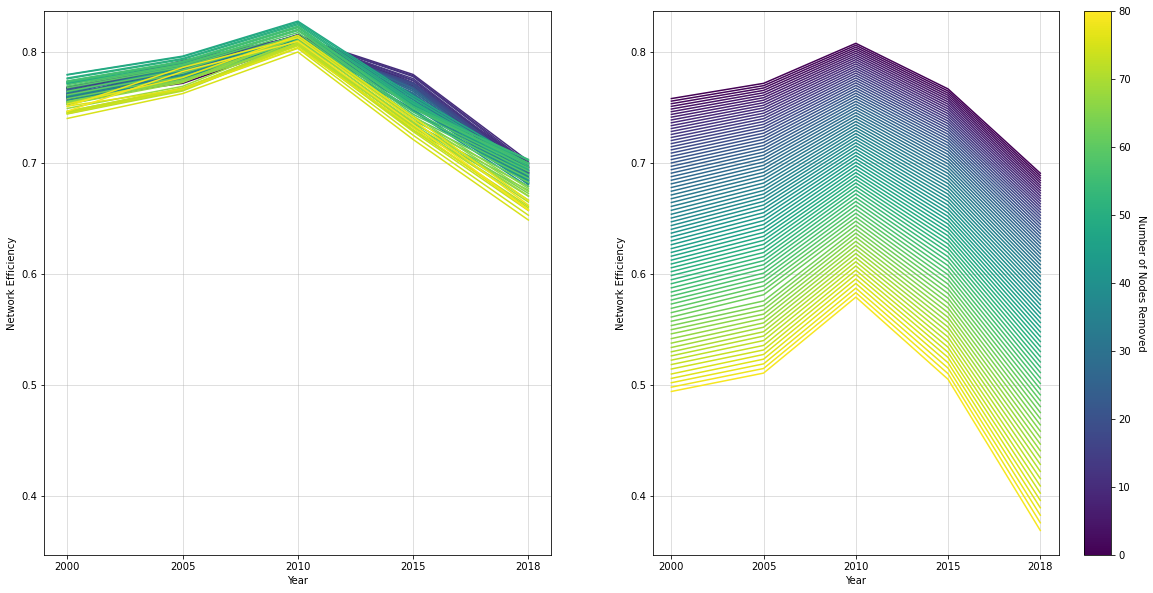

In [34]:
# make a plot where the x axis are the years, the y axis the network efficiency, and there are a total of 20 lines, one for each iteration in which a node was removed
# color each plot with a colormap according to the number of nodes removed
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
for n in range(node_removals):
    ax[0].plot(attack_efficiency.index, attack_efficiency[n], color=plt.cm.viridis(n/node_removals))
    ax[1].plot(attack_efficiency_targeted.index, attack_efficiency_targeted[n], color=plt.cm.viridis(n/node_removals))
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Network Efficiency')
ax[0].grid(alpha=0.5)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Network Efficiency')
ax[1].grid(alpha=0.5)

# get the max and min values of the y axis
ymin = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0])
ymax = max(ax[0].get_ylim()[1], ax[1].get_ylim()[1])
# set the y axis limits
ax[0].set_ylim(ymin, ymax)
ax[1].set_ylim(ymin, ymax)

# add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=node_removals))
sm._A = []
cbar = fig.colorbar(sm)
cbar.set_label('Number of Nodes Removed', rotation=270, labelpad=15)

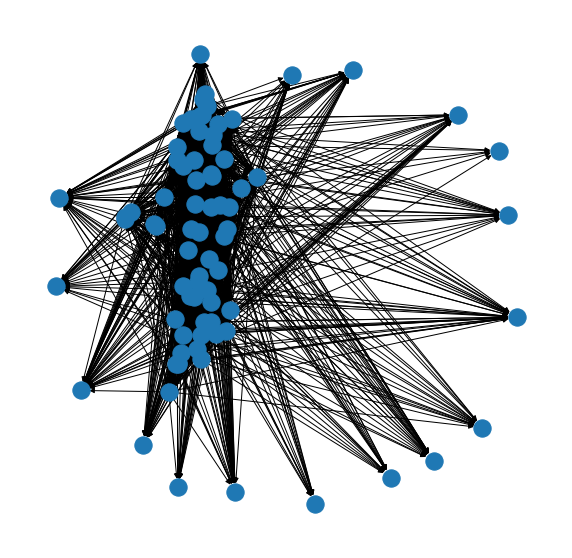

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(G_Years['2010'], ax=ax)

In [67]:
from src import simulation
importlib.reload(simulation)

<module 'src.simulation' from '/home/mf/Documents/Github/ML_Self_Course/Kaggle/Trade_Network/src/simulation.py'>

In [68]:
init_vals = {'USA': 1}
sim_Vals = simulation.run_sim(G_Years['2010'], init_vals, 20)

In [71]:
for country in sim_Vals.keys():
    if sim_Vals[country][-1] != 0:
        print(country, sim_Vals[country][-1])

PLW 1.5911050176697792e-06
USA 1.0
